In [41]:
import sys
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from cycler import cycler

plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['axes.labelsize'] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['figure.figsize'] = [10, 7]

cc = (cycler(linestyle=['-', '--', '-.']) * cycler(color=list('bgrcmk')))

plt.rc('axes', prop_cycle=cc)

In [42]:
#os.environ['OFT_ROOTPATH'] = '/Users/ansonbraun/Documents/Columbia/Research/OpenFUSIONToolkit/src/'

thincurr_python_path = os.getenv('OFT_ROOTPATH')
if thincurr_python_path is not None:
    sys.path.append(os.path.join(thincurr_python_path,'python'))
#sys.path.append('/Users/sophiaguizzo/Documents/OFT_thincurr/install_release/python')
from OpenFUSIONToolkit.ThinCurr import ThinCurr
from OpenFUSIONToolkit.ThinCurr.sensor import circular_flux_loop, save_sensors, flux_loop
from OpenFUSIONToolkit.util import build_XDMF
from OpenFUSIONToolkit.io import histfile
from OpenFUSIONToolkit.TokaMaker.util import create_isoflux, read_eqdsk

In [43]:
arc_eq = read_eqdsk('../geqdsk-FreeGS-ARC-v2E-20250105.txt')
bdry = arc_eq['rzout']

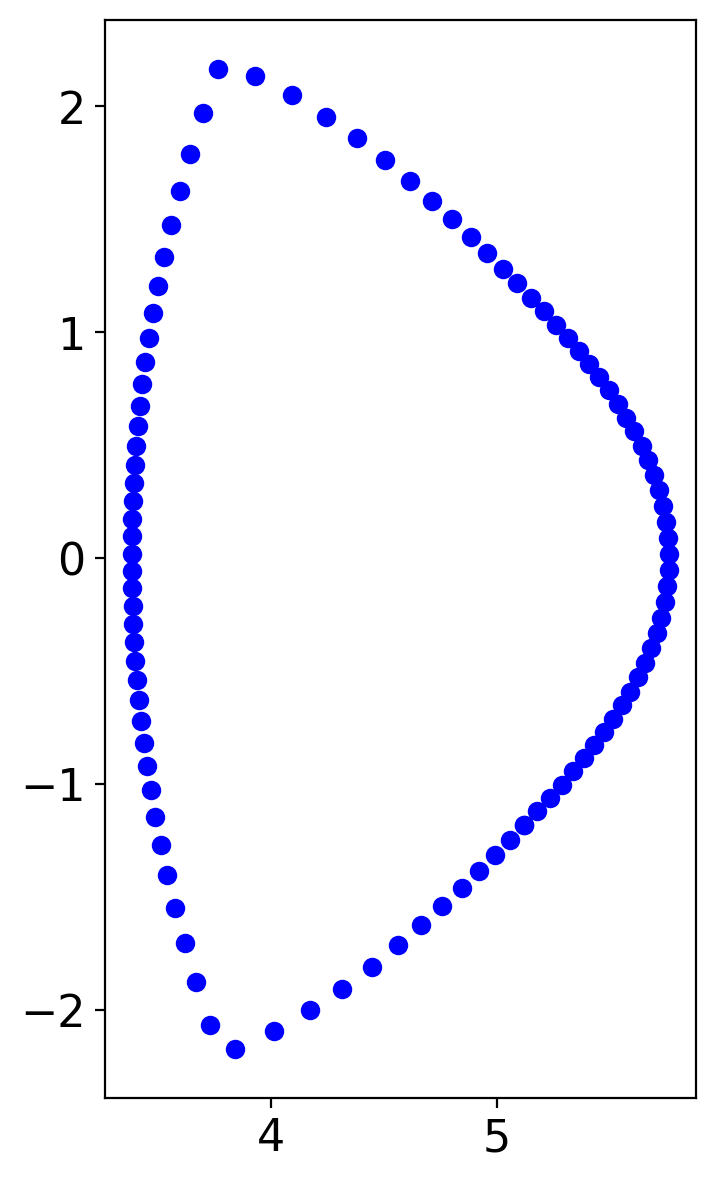

In [44]:
plt.scatter(bdry[:,0], bdry[:,1])
plt.gca().set_aspect(aspect = 1)

In [64]:
bdry_mod = np.array(resize_polygon(bdry, -0.28))

In [65]:
new_bdry = []
for i in range(len(bdry_mod[:,0])-1):
    if i == 0:
        dist = np.sqrt((bdry_mod[i,0]-bdry_mod[-1,0])**2 + (bdry_mod[i,1]-bdry_mod[-1,1])**2)
    else:
        dist = np.sqrt((bdry_mod[i,0]-bdry_mod[i-1,0])**2 + (bdry_mod[i,1]-bdry_mod[i-1,1])**2)
    n = int(np.round(dist/0.035))
    if n >1:
        for j in range(1,n):
            new_pt = bdry_mod[i-1,:]+ j/n*(bdry_mod[i,:]- bdry_mod[i-1,:])
            new_bdry.append(new_pt)
    new_bdry.append(bdry_mod[i,:])

new_bdry = np.array(new_bdry)

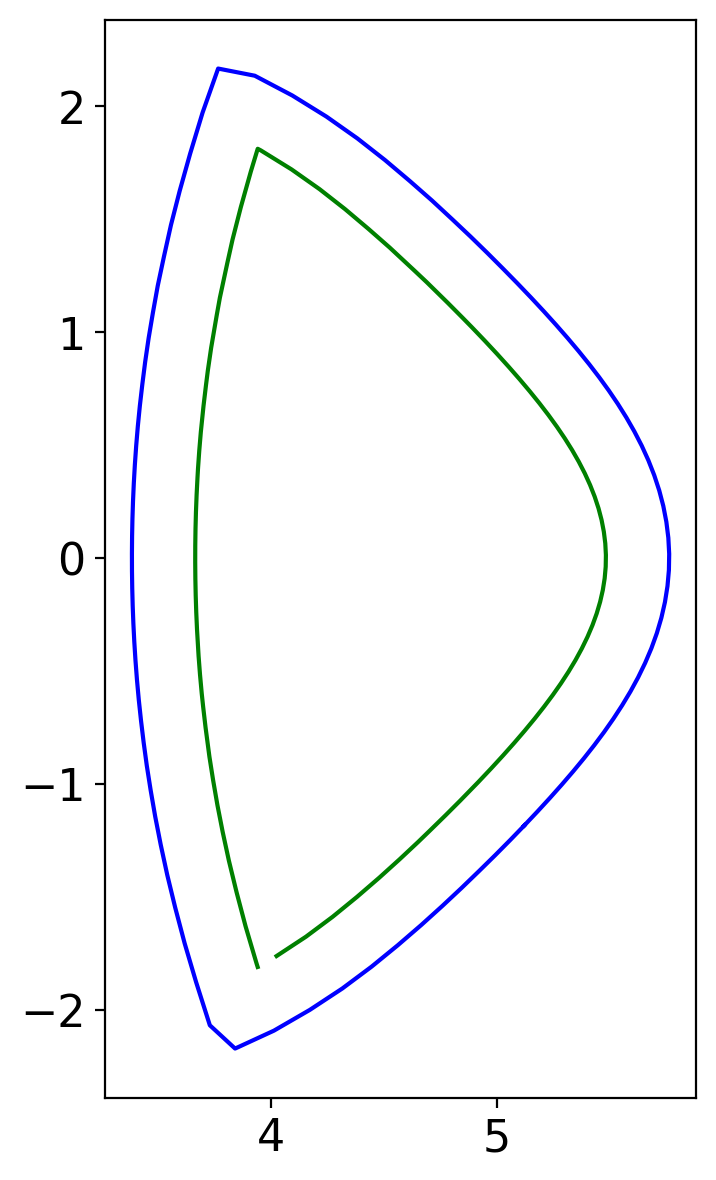

In [66]:
plt.plot(bdry[:,0], bdry[:,1])
plt.plot(new_bdry[:,0], new_bdry[:,1])
plt.gca().set_aspect(aspect = 1)

In [67]:
from shapely.geometry import Polygon

def resize_polygon(polygon_coords, offset):
    """
    Resizes the given 2D polygon by the specified offset distance.
    
    Parameters:
    - polygon_coords: List of tuples [(x1, y1), (x2, y2), ..., (xn, yn)]
      representing the coordinates of the polygon's vertices.
    - offset: The distance by which to resize the polygon. Positive values expand, negative values shrink.
    
    Returns:
    - A list of tuples representing the resized polygon's vertices.
    """
    
    # Create a Shapely polygon from the coordinates
    polygon = Polygon(polygon_coords)
    
    # Apply the offset (buffer operation)
    resized_polygon = polygon.buffer(offset, resolution=16)  # Resolution defines smoothness
    
    # Check if the result is a valid polygon
    if resized_polygon.geom_type == 'Polygon':
        # Return the resized polygon's exterior coordinates as a list of tuples
        return list(resized_polygon.exterior.coords)
    else:
        raise ValueError("Buffer operation resulted in a non-polygon geometry.")

In [68]:
def cart(r,z, phi):
    x = r*np.cos(phi)
    y = r*np.sin(phi)
    return x,y,z

def circle(r0, z0, rad, npts = 8):
    thetas = np.linspace(0,2*np.pi, npts)
    return r0 + rad*np.cos(thetas), z0 + rad*np.sin(thetas)

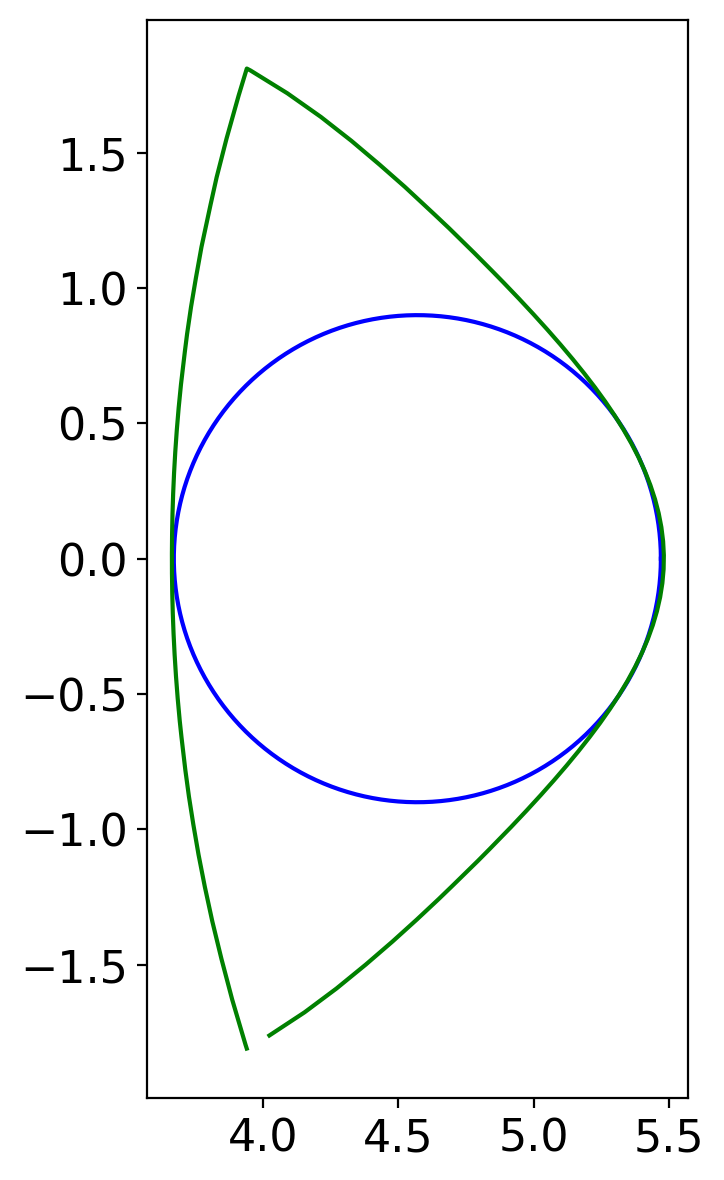

In [69]:
r,z = circle(4.57,0, 0.9, npts = 180 )
plt.plot(r, z)
plt.plot(new_bdry[:,0], new_bdry[:,1])
plt.gca().set_aspect(aspect = 1)

In [70]:
original_file = 'arc_empty.xml'
new_file = 'arc_200_mod_28.xml'

with open(original_file, 'r') as file:
    lines_og = file.readlines()

phis = np.linspace(0,2*np.pi, 200, endpoint = False)

insert = []
for p in phis:
    x,y,z = cart(new_bdry[:,0],new_bdry[:,1],p)
    insert.append('        <coil npts="' + str(len(x)) + '">\n')
    for i in range(len(x)):
        insert.append('        ' + str(round(x[i],3)) + ' ' + str(round(y[i],3))+ ' ' + str(round(z[i],3)) + '\n')
    insert.append('        </coil>\n')

lines = lines_og[:5] + insert + lines_og[5:]

## Write the modified content to the new file
with open(new_file, 'w') as file:
    file.writelines(lines)